## Imports

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Read base dataset

In [38]:
data= pd.read_csv('/Users/alexnaderspude/Desktop/Desktop/TUM MMT/DTU Kurs/Group Project/Trips_2018.csv')

### Basic information

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17548339 entries, 0 to 17548338
Data columns (total 14 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   Unnamed: 0               int64  
 1   tripduration             int64  
 2   starttime                object 
 3   stoptime                 object 
 4   start_station_id         float64
 5   start_station_latitude   float64
 6   start_station_longitude  float64
 7   end_station_id           float64
 8   end_station_latitude     float64
 9   end_station_longitude    float64
 10  bikeid                   int64  
 11  usertype                 object 
 12  birth_year               int64  
 13  gender                   int64  
dtypes: float64(6), int64(5), object(3)
memory usage: 1.8+ GB


In [40]:
data.describe()

,Unnamed: 0,tripduration,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,birth_year,gender
count,1.754834e+07,1.754834e+07,1.754584e+07,1.754834e+07,1.754834e+07,1.754584e+07,1.754834e+07,1.754834e+07,1.754834e+07,1.754834e+07,1.754834e+07
mean,8.774169e+06,9.887432e+02,1.589282e+03,4.073737e+01,-7.398260e+01,1.580830e+03,4.073704e+01,-7.398281e+01,2.656141e+04,1.978993e+03,1.148613e+00
std,5.065769e+06,1.889584e+04,1.439432e+03,3.225813e-02,1.912753e-02,1.438502e+03,3.206583e-02,1.919611e-02,6.222916e+03,1.192922e+01,5.438043e-01
min,0.000000e+00,6.100000e+01,7.200000e+01,4.064654e+01,-7.402535e+01,7.200000e+01,4.064654e+01,-7.408364e+01,1.452900e+04,1.885000e+03,0.000000e+00
25%,4.387084e+06,3.580000e+02,3.800000e+02,4.071755e+01,-7.399521e+01,3.800000e+02,4.071755e+01,-7.399595e+01,2.029300e+04,1.969000e+03,1.000000e+00
50%,8.774169e+06,6.050000e+02,5.050000e+02,4.073818e+01,-7.398565e+01,5.050000e+02,4.073756e+01,-7.398602e+01,2.827000e+04,1.981000e+03,1.000000e+00
75%,1.316125e+07,1.060000e+03,3.249000e+03,4.075763e+01,-7.397283e+01,3.249000e+03,4.075725e+01,-7.397344e+01,3.185200e+04,1.989000e+03,1.000000e+00
max,1.754834e+07,1.951005e+07,3.721000e+03,4.550636e+01,-7.356891e+01,3.721000e+03,4.550636e+01,-7.356891e+01,3.583100e+04,2.002000e+03,2.000000e+00


In [41]:
data.isnull().sum()

Unnamed: 0                    0
tripduration                  0
starttime                     0
stoptime                      0
start_station_id           2497
start_station_latitude        0
start_station_longitude       0
end_station_id             2497
end_station_latitude          0
end_station_longitude         0
bikeid                        0
usertype                      0
birth_year                    0
gender                        0
dtype: int64

### Convert data types

In [42]:
date_columns = ["starttime", "stoptime"]
categorical_columns = ["gender", "usertype", "start_station_id", "end_station_id"]
data[date_columns] = data[date_columns].apply(pd.to_datetime)
data[categorical_columns] = data[categorical_columns].apply(lambda x: x.astype('category'))

### Drop unnecesary column

In [43]:
data = data.drop(columns=['Unnamed: 0'])

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17545760 entries, 0 to 17545759
Data columns (total 17 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   tripduration             int64         
 1   starttime                datetime64[ns]
 2   stoptime                 datetime64[ns]
 3   start_station_id         category      
 4   start_station_latitude   float64       
 5   start_station_longitude  float64       
 6   end_station_id           category      
 7   end_station_latitude     float64       
 8   end_station_longitude    float64       
 9   bikeid                   int64         
 10  usertype                 category      
 11  birth_year               int64         
 12  gender                   category      
 13  pickup_hour              int64         
 14  pickup_day               object        
 15  dropoff_hour             int64         
 16  dropoff_day              object        
dtypes: category(4), datetime6

In [44]:
data.head()

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1


In [45]:
data = data.sort_values(by='starttime').reset_index(drop=True)

### Add date information

In [46]:
data["pickup_hour"] = data["starttime"].dt.hour
data["pickup_day"] = data["starttime"].dt.date
data["dropoff_hour"] = data["stoptime"].dt.hour
data["dropoff_day"] = data["stoptime"].dt.date

In [47]:
display(data.head())

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,pickup_hour,pickup_day,dropoff_hour,dropoff_day
0,196,2018-01-01 00:01:50.650,2018-01-01 00:05:07.438,315.0,40.703554,-74.006702,259.0,40.701221,-74.012342,18534,Subscriber,1997,1,0,2018-01-01,0,2018-01-01
1,207,2018-01-01 00:02:43.918,2018-01-01 00:06:11.383,3224.0,40.739974,-74.005139,470.0,40.743453,-74.000040,19651,Subscriber,1978,1,0,2018-01-01,0,2018-01-01
2,613,2018-01-01 00:03:15.116,2018-01-01 00:13:28.480,386.0,40.714948,-74.002345,2008.0,40.705693,-74.016777,21678,Subscriber,1982,1,0,2018-01-01,0,2018-01-01
3,375,2018-01-01 00:06:43.709,2018-01-01 00:12:59.450,466.0,40.743954,-73.991449,325.0,40.736245,-73.984738,29822,Subscriber,1982,1,0,2018-01-01,0,2018-01-01
4,402,2018-01-01 00:06:56.924,2018-01-01 00:13:39.792,438.0,40.727791,-73.985649,380.0,40.734011,-74.002939,30722,Subscriber,1989,1,0,2018-01-01,0,2018-01-01


### Extracting all distinct stations and cleaning

In [48]:
# extract distinct stations
stations_start = data[['start_station_id', 'start_station_latitude', 'start_station_longitude']].drop_duplicates().rename(columns={
    'start_station_id': 'station_id',
    'start_station_latitude': 'station_latitude',
    'start_station_longitude': 'station_longitude'
})

stations_end = data[['end_station_id', 'end_station_latitude', 'end_station_longitude']].drop_duplicates().rename(columns={
    'end_station_id': 'station_id',
    'end_station_latitude': 'station_latitude',
    'end_station_longitude': 'station_longitude'
})

stations = pd.concat([stations_start, stations_end]).drop_duplicates().reset_index(drop=True)

start_stations_set = set(stations_start['station_id'])
end_stations_set = set(stations_end['station_id'])

def categorize_station(station_id):
    in_start = station_id in start_stations_set
    in_end = station_id in end_stations_set
    
    if in_start and in_end:
        return 'both'
    elif in_start:
        return 'start'
    elif in_end:
        return 'end'
    else:
        return 'No station id'  # if station doesn't appear in either

# Add category column to stations DataFrame
stations['category'] = stations['station_id'].apply(categorize_station)


stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 957 entries, 0 to 956
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   station_id         851 non-null    float64
 1   station_latitude   957 non-null    float64
 2   station_longitude  957 non-null    float64
 3   category           957 non-null    object 
dtypes: float64(3), object(1)
memory usage: 30.0+ KB


In [49]:
stations.describe()

,station_id,station_latitude,station_longitude
count,851.000000,957.000000,957.000000
mean,2369.844888,40.755821,-73.964898
std,1422.403023,0.223958,0.040197
min,72.000000,40.646538,-74.083639
25%,466.500000,40.705693,-73.990539
50%,3185.000000,40.740343,-73.970416
75%,3470.500000,40.775794,-73.946041
max,3721.000000,45.506364,-73.568906


In [50]:
outlier_stations = stations[stations['station_latitude'] >= 41]
outlier_stations.info()
outlier_stations.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2 entries, 744 to 752
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   station_id         2 non-null      float64
 1   station_latitude   2 non-null      float64
 2   station_longitude  2 non-null      float64
 3   category           2 non-null      object 
dtypes: float64(3), object(1)
memory usage: 80.0+ bytes


,station_id,station_latitude,station_longitude,category
744,3488.0,45.506364,-73.569463,both
752,3650.0,45.506264,-73.568906,both


In [51]:
# remove outlier based on latitude
stations = stations[stations['station_latitude'] < 41]
stations_start = stations_start[stations_start['station_latitude'] < 41]
stations_end = stations_end[stations_end['station_latitude'] < 41]
stations.describe()


,station_id,station_latitude,station_longitude
count,849.000000,955.000000,955.000000
mean,2367.020024,40.745873,-73.965727
std,1422.879904,0.053409,0.035919
min,72.000000,40.646538,-74.083639
25%,466.000000,40.705537,-73.990540
50%,3184.000000,40.740259,-73.970776
75%,3468.000000,40.775693,-73.946181
max,3721.000000,40.869000,-73.878000


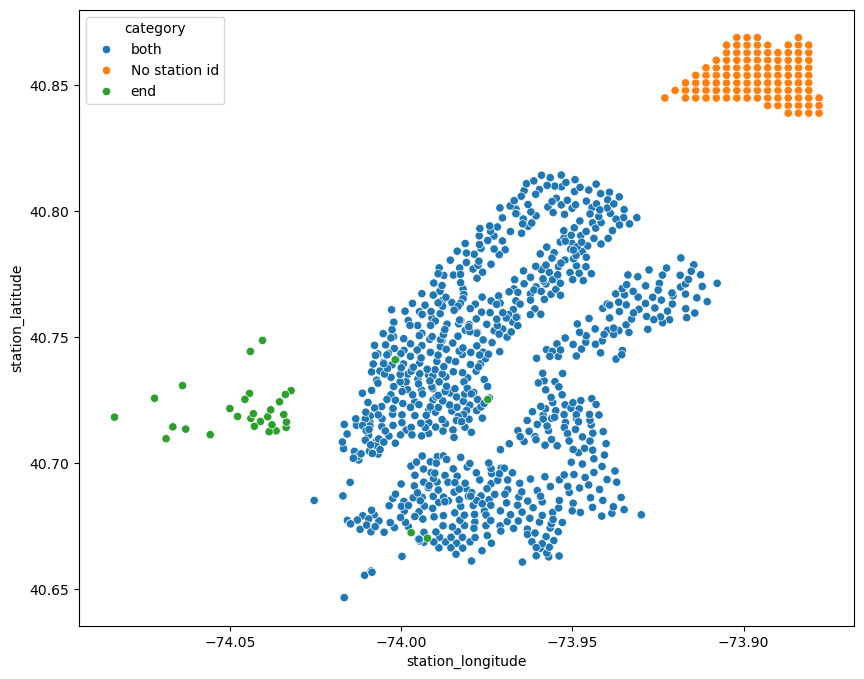

In [52]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=stations, x='station_longitude', y='station_latitude', hue='category')
plt.show()

The orange category seems suspicious, they are categorized a s none, because they do not have a station_id, and they have a very regular pattern

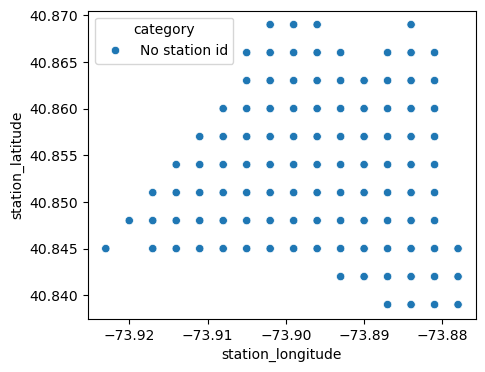

In [53]:
fig, ax = plt.subplots(figsize=(5, 4))
sns.scatterplot(data=stations[stations['category'] == 'No station id'], x='station_longitude', y='station_latitude', hue='category')
plt.show()

In [54]:
stations = stations[stations['category'] != 'No station id']

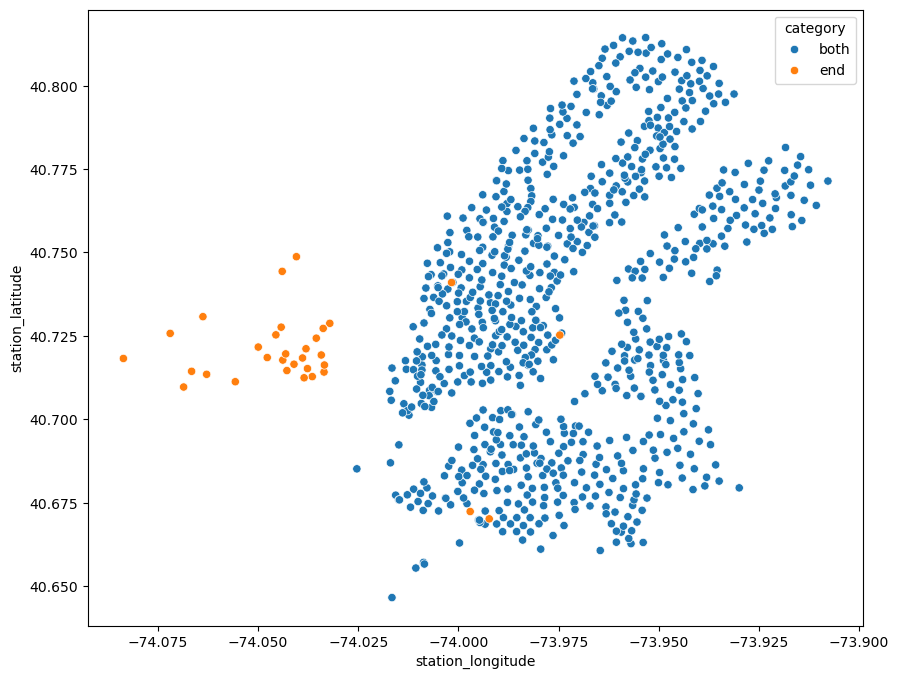

In [55]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=stations, x='station_longitude', y='station_latitude', hue='category')
plt.show()

In [56]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 849 entries, 0 to 956
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   station_id         849 non-null    float64
 1   station_latitude   849 non-null    float64
 2   station_longitude  849 non-null    float64
 3   category           849 non-null    object 
dtypes: float64(3), object(1)
memory usage: 33.2+ KB


Lets use this new knowledge to exclude the trips originating/ending at the outlier and the stations that have no station id and looked like "fake" data

In [57]:
data = data.dropna(subset=['start_station_id', 'end_station_id'])
outlier_ids = outlier_stations['station_id'].tolist()
for value_to_remove in outlier_ids:
    mask_to_keep = (data['start_station_id'] != value_to_remove) & (data['end_station_id'] != value_to_remove)
    data = data[mask_to_keep]

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17545760 entries, 0 to 17548338
Data columns (total 17 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   tripduration             int64         
 1   starttime                datetime64[ns]
 2   stoptime                 datetime64[ns]
 3   start_station_id         category      
 4   start_station_latitude   float64       
 5   start_station_longitude  float64       
 6   end_station_id           category      
 7   end_station_latitude     float64       
 8   end_station_longitude    float64       
 9   bikeid                   int64         
 10  usertype                 category      
 11  birth_year               int64         
 12  gender                   category      
 13  pickup_hour              int32         
 14  pickup_day               object        
 15  dropoff_hour             int32         
 16  dropoff_day              object        
dtypes: category(4), datetime64[ns]

### Saving CSVs 

In [59]:
data.to_csv('/Users/alexnaderspude/Desktop/Desktop/TUM MMT/DTU Kurs/Group Project/Trips_2018.csv', index=False)
stations.to_csv('/Users/alexnaderspude/Desktop/Desktop/TUM MMT/DTU Kurs/Group Project/Stations_2018.csv', index=False)